<a href="https://colab.research.google.com/github/Hemanth-tech112/Color-depiction-and-push-notification-system-for-daily-sounds/blob/main/MP_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import IPython.display as ipd
import os
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense,Dropout,Activation

In [ ]:
import requests
import json

def pushbullet_noti(title, body):

    TOKEN = 'o.wWIKfxozypLiqKYF9xMskSubtPynLO0D' # Pass your Access Token here
    # Make a dictionary that includes, title and body
    msg = {"type": "note", "title": title, "body": body}
    # Sent a posts request
    resp = requests.post('https://api.pushbullet.com/v2/pushes',
                        data=json.dumps(msg),
                        headers={'Authorization': 'Bearer ' + TOKEN,
                                'Content-Type': 'application/json'})
    if resp.status_code != 200: # Check if fort message send with the help of status code
        raise Exception('Error', resp.status_code)
    else:
        print('Message sent')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
data = pd.read_csv('/content/drive/MyDrive/majorproject/audio33.csv')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install gtts

In [ ]:
mfc=[]
chr=[]
me=[]
ton=[]
lab=[]
for i in tqdm(range(len(data))):
  f_name='/content/drive/MyDrive/majorproject/audio/soundd/'+str(data.filename[i])
  X, s_rate = librosa.load(f_name)
  mf = np.mean(librosa.feature.mfcc(y=X, sr=s_rate).T,axis=0)
  mfc.append(mf)
  l = data.category[i]
  lab.append(l)
  m = np.mean(librosa.feature.melspectrogram(y=X,sr=s_rate).T,axis=0)
  me.append(m)
  s = np.abs(librosa.stft(X))
  c = np.mean(librosa.feature.chroma_stft(S=s,sr=s_rate).T,axis=0)
  chr.append(c)
  try:
    t = np.mean(librosa.feature.tonnetz(y = librosa.effects.harmonic(X),sr=s_rate).T,axis=0)
    ton.append(t)
  except:
    print(f_name)

100%|██████████| 76/76 [01:50<00:00,  1.46s/it]


In [ ]:
mfcc = pd.DataFrame(mfc)
mfcc.to_csv('/content/drive/MyDrive/majorproject/features/mfc.csv',index = False)
chrr = pd.DataFrame(chr)
chrr.to_csv('/content/drive/MyDrive/majorproject/features/chr.csv',index = False)
mee = pd.DataFrame(me)
mee.to_csv('/content/drive/MyDrive/majorproject/features/me.csv',index = False)
tonn = pd.DataFrame(ton)
tonn.to_csv('/content/drive/MyDrive/majorproject/features/ton.csv',index = False)
la = pd.DataFrame(lab)
la.to_csv('/content/drive/MyDrive/majorproject/features/labels.csv',index = False)

Index(['chirping_birds', 'clapping', 'clock_alarm', 'crow', 'dog',
       'door_wood_knock', 'footsteps'],
      dtype='object')
Training (60, 20)
(60, 7)
Validation (8, 20)
(8, 7)
Test (8, 20)
Epoch 1/100
3/3 [==============================] - 1s 137ms/step - loss: 1.8826 - accuracy: 0.2167 - val_loss: 1.8375 - val_accuracy: 0.1250
Epoch 2/100
3/3 [==============================] - 0s 28ms/step - loss: 1.8573 - accuracy: 0.2833 - val_loss: 1.7916 - val_accuracy: 0.2500
Epoch 3/100
3/3 [==============================] - 0s 19ms/step - loss: 1.6816 - accuracy: 0.3500 - val_loss: 1.7619 - val_accuracy: 0.1250
Epoch 4/100
3/3 [==============================] - 0s 19ms/step - loss: 1.5659 - accuracy: 0.4000 - val_loss: 1.7163 - val_accuracy: 0.1250
Epoch 5/100
3/3 [==============================] - 0s 31ms/step - loss: 1.5037 - accuracy: 0.3833 - val_loss: 1.6715 - val_accuracy: 0.1250
Epoch 6/100
3/3 [==============================] - 0s 34ms/step - loss: 1.5153 - accuracy: 0.4667 - val_l

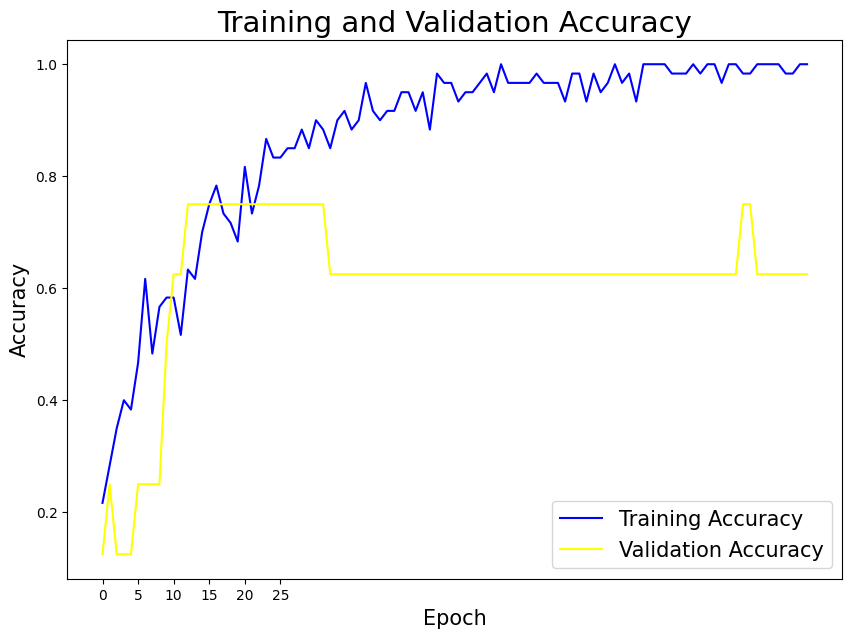

In [ ]:
features=[]
for i in range(len(ton)):
  features.append(np.concatenate((me[i],mfc[i],ton[i],chr[i]),axis = 0))

la = pd.get_dummies(lab)
label_columns = la.columns
target = la.to_numpy()
print(label_columns)

tran = StandardScaler()
features_train = tran.fit_transform(mfc)

feat_train = features_train[:60]
target_train = target[:60]
y_train = features_train[60:68]
y_val = target[60:68]
test_data = features_train[68:]
test_label = lab[68:]

print("Training",feat_train.shape)
print(target_train.shape)
print("Validation",y_train.shape)
print(y_val.shape)
print("Test",test_data.shape)

model = Sequential()
model.add(Dense(186, input_shape=(20,), activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.6))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax'))
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

history = model.fit(feat_train, target_train, batch_size=25, epochs=100, validation_data=(y_train, y_val))

train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.figure(figsize=(10,7))
plt.plot(train_acc,label='Training Accuracy',color='blue')
plt.plot(val_acc,label='Validation Accuracy',color = 'yellow')
plt.title('Training and Validation Accuracy',fontsize=21)
plt.xlabel('Epoch',fontsize=15)
plt.legend(fontsize=15)
plt.ylabel('Accuracy',fontsize=15)
plt.xticks(range(0,30,5),range(0,30,5))

predict = model.predict(test_data)
predict = np.argmax(predict,axis=1)
predict

prediction=[]
for i in predict:
  j = label_columns[i]
  prediction.append(j)
prediction

k = 0
for i,j in zip(test_label,prediction):
  if(i==j):
    k+=1
print(k)
print(test_label)
print(prediction)

In [ ]:
# all imports
from IPython.display import Javascript
from google.colab import output
from base64 import b64decode

RECORD = """
const sleep  = time => new Promise(resolve => setTimeout(resolve, time))
const b2text = blob => new Promise(resolve => {
  const reader = new FileReader()
  reader.onloadend = e => resolve(e.srcElement.result)
  reader.readAsDataURL(blob)
})
var record = time => new Promise(async resolve => {
  stream = await navigator.mediaDevices.getUserMedia({ audio: true })
  recorder = new MediaRecorder(stream)
  chunks = []
  recorder.ondataavailable = e => chunks.push(e.data)
  recorder.start()
  await sleep(time)
  recorder.onstop = async ()=>{
    blob = new Blob(chunks)
    text = await b2text(blob)
    resolve(text)
  }
  recorder.stop()
})
"""

def record(sec=6):
  print("SPeak now")
  display(Javascript(RECORD))
  s = output.eval_js('record(%d)' % (sec*1000))
  b = b64decode(s.split(',')[1])
  with open('audio.wav','wb') as f:
    f.write(b)
  print("Done Recording")
  return 'audio.wav'
record()

SPeak now


<IPython.core.display.Javascript object>

Done Recording


'audio.wav'

In [ ]:
ipd.Audio("/content/audio.wav")

In [ ]:
f_nname='/content/audio.wav'
Xx, ss_rate = librosa.load(f_nname)
mff = np.mean(librosa.feature.mfcc(y=Xx, sr=ss_rate).T,axis=0)
src=tran.transform(mff.reshape(1,-1))
#print(src)

i = np.argmax(model.predict(src), axis=-1)
print("Predicted Value is",label_columns[i])
#print(model.predict(src),label_columns)

from gtts import gTTS
from IPython.display import Audio
if(i==0):
  tts = gTTS('Alexa,change the colour of the bulb to Green',tld='co.in')
  print('Predicted Sound is Chirping Birds Sound')
  pushbullet_noti("Sound", "Chirping Birds Sound")
  tts.save('AudioOut.wav')
if(i==1):
   tts = gTTS('Alexa,change the colour of the bulb to Pink',tld='co.in')
   pushbullet_noti("Sound", "Clapping")
   print('Predicted Sound is Clapping')
   tts.save('AudioOut.wav')
if(i==2):
   tts = gTTS('Alexa,change the colour of the bulb to Yellow',tld='co.in')
   pushbullet_noti("Sound", "Alaram Sound")
   print('Predicted Sound is Alaram Sound')
   tts.save('AudioOut.wav')
if(i==3):
   tts = gTTS('Alexa,change the colour of the bulb to Gold',tld='co.in')
   pushbullet_noti("Sound", "Crow sound")
   print('Predicted Sound is Crow sound')
   tts.save('AudioOut.wav')
if(i==4):
   tts = gTTS('Alexa,change the colour of the bulb to Red',tld='co.in')
   pushbullet_noti("Sound", "Dog Barking")
   print('Predicted Sound is Dog Barking')
   tts.save('AudioOut.wav')
if(i==5):
   tts = gTTS('Alexa,change the colour of the bulb to Blue',tld='co.in')
   pushbullet_noti("Sound", "Door Wood Knock")
   print('Predicted Sound is Door Wood Knock')
   tts.save('AudioOut.wav')
if(i==6):
   tts = gTTS('Alexa,change the colour of the bulb to Cyan',tld='co.in')
   pushbullet_noti("Sound", "Foot Steps")
   print('Predicted Sound is Foot Steps')
   tts.save('AudioOut.wav')
Audio('AudioOut.wav',autoplay=True)


<ipython-input-11-05f005b16171>:2: UserWarning: PySoundFile failed. Trying audioread instead.
  Xx, ss_rate = librosa.load(f_nname)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 [==============================] - 0s 44ms/step
Predicted Value is Index(['crow'], dtype='object')
Message sent
Predicted Sound is Crow sound
